In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'msft' # ticker symbol
train = 0 # 1 for train, 0 for pass
days_ahead = 1 # for predicting 1, 3, or 5 days ahead
days_back = -1 # -1 for current data point, -2 for two days ago, etc...
cv = 5 # number of cross validation folds
model_name = 'Random Forest Classifier' # for display on charts, not a tuning parameter

In [3]:
# Extract, Transform, Load, and Train Test Split
# Dictionary of IPO Dates
start_dates = {'a': '11/15/1999' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'aapl':'12/12/1980' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'acy': '01/18/1998' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'adbe': '08/11/1986' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'alb': '02/21/1994' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'amat': '03/16/1980' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'amd': '03/17/1980' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'amgn': '06/13/1983' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'amzn': '05/12/1997' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'baba': '09/15/2014' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'bac': '02/19/1973' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'bpmc': '04/27/2015' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'crm': '06/23/2004' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'crsp': '10/16/2016' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'dq': '10/04/2010' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'esgv': '09/16/2018' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'fslr': '11/12/2006' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'goog': '08/16/2004' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'ibm': '01/02/1962' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'intc': '03/16/1980' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'iyw': '05/15/2000' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'lng': '04/04/1994' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'ma': '05/21/2006' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'mdb': '10/15/2017' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'msft': '03/10/1986' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'mu': '05/28/1984' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'nee': '02/19/1973' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'nio': '09/10/2018' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'nvda': '01/22/1999' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'pacb': '10/25/2010' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'pypl': '07/05/2015' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'qgen': '06/24/1996' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'run': '08/02/2015' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'okta': '04/03/2017' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'orcl': '03/10/1986' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'qqq': '03/08/1999' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'srpt': '06/02/1997' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'tpic': '07/17/2016' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'tsla': '06/29/2010' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'v': '03/16/2008' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'vbiv': '09/04/2002' # Updated 3/818/21 1D, 3D, 5D ahead
               , 'vbr': '01/26/2004' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'viov': '09/06/2010' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'vgt': '01/26/2004' # Updated 3/18/21 1D, 3D, 5D ahead
               , 'xlk': '12/21/1998' # Updated 3/18/21 1D, 3D, 5D ahead
              }

In [4]:
# X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, start_dates[stock_name], days_ahead)
# stock_df.tail(10)

In [5]:
# GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
# if train == 1:
#     a.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)
# elif train == 0:
#     pass

In [6]:
# Load RandomForextClassifier Model
# rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

In [7]:
# ROC Curve
# a.roc_plot(y_test, y_probs, stock_name, model_name)

In [8]:
# Precision Recall Curve
# a.prec_recall(y_test, y_probs, stock_name, model_name)

In [9]:
# Confusion Matrix
# a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
# a.cross_validation(rfc_model
#                    , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
#                    , stock_df['direction']
#                    , cv = 5
#                   )

### Prediction...

In [11]:
# Prediction, use last day of data
# stock_df.iloc[-1]

In [12]:
# import numpy as np
# last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-days_back]
# last

In [13]:
# stock_df['adj'].describe()

In [14]:
# if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
#     print(f'Buy {stock_name} {days_ahead} day(s) ahead')
# else:
#     print(f'Sell or hold {stock_name} {days_ahead} day(s) ahead')

### Strategy Returns...

In [15]:
# returns on strategy column
# stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
# stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [16]:
# stock_df.tail(5)

In [17]:
# Don't trade every day!
# import matplotlib.pyplot as plt
# test_length = len(y_test)
# (stock_df['returns'][-test_length:] + 1).cumprod().plot()
# plt.title(f'{stock_name} Expected Returns %');

In [18]:
# Model returns if bought on predictions of 1
# returns_on_ones = []
# for idx in range(-test_length, 0):
#     if stock_df['prediction'][idx] == 1:
#         returns_on_ones.append(1 + stock_df['returns'][idx])

# returns = 1
# for x in returns_on_ones:
#     returns *= x
# returns

In [19]:
# multiple times original investment, not bad but...

In [20]:
# If purchased in 2012 and left it until now
# test_idx = int(len(stock_df)*0.75)
# (stock_df['Close'][-1] - stock_df['Close'][-test_idx]) / stock_df['Close'][-test_idx]

In [21]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/

### Training

Training is done once a week on Saturday and Sunday

In [22]:
len(start_dates)

45

In [23]:
import itertools as itr
start_dates1 = dict(itr.islice(start_dates.items(), 0, 15))
start_dates1

{'a': '11/15/1999',
 'aapl': '12/12/1980',
 'acy': '01/18/1998',
 'adbe': '08/11/1986',
 'alb': '02/21/1994',
 'amat': '03/16/1980',
 'amd': '03/17/1980',
 'amgn': '06/13/1983',
 'amzn': '05/12/1997',
 'baba': '09/15/2014',
 'bac': '02/19/1973',
 'bpmc': '04/27/2015',
 'crm': '06/23/2004',
 'crsp': '10/16/2016',
 'dq': '10/04/2010'}

In [24]:
start_dates2 = dict(itr.islice(start_dates.items(), 15, 30))
start_dates2

{'esgv': '09/16/2018',
 'fslr': '11/12/2006',
 'goog': '08/16/2004',
 'ibm': '01/02/1962',
 'intc': '03/16/1980',
 'iyw': '05/15/2000',
 'lng': '04/04/1994',
 'ma': '05/21/2006',
 'mdb': '10/15/2017',
 'msft': '03/10/1986',
 'mu': '05/28/1984',
 'nee': '02/19/1973',
 'nio': '09/10/2018',
 'nvda': '01/22/1999',
 'pacb': '10/25/2010'}

In [25]:
start_dates3 = dict(itr.islice(start_dates.items(), 30, 45+1))
start_dates3

{'pypl': '07/05/2015',
 'qgen': '06/24/1996',
 'run': '08/02/2015',
 'okta': '04/03/2017',
 'orcl': '03/10/1986',
 'qqq': '03/08/1999',
 'srpt': '06/02/1997',
 'tpic': '07/17/2016',
 'tsla': '06/29/2010',
 'v': '03/16/2008',
 'vbiv': '09/04/2002',
 'vbr': '01/26/2004',
 'viov': '09/06/2010',
 'vgt': '01/26/2004',
 'xlk': '12/21/1998'}

In [26]:
#Train 15 at a time!
# stocks = [x for x in start_dates1]
# days_ahead = [1, 3, 5]
# cv = 5
# for stock in stocks:
#     for days in days_ahead:
#         X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
#         a.rfc_GridSearch(X_train, y_train, stock, days, cv)
# len(stocks)

# stocks = [x for x in start_dates2]
# days_ahead = [1, 3, 5]
# cv = 5
# for stock in stocks:
#     for days in days_ahead:
#         X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
#         a.rfc_GridSearch(X_train, y_train, stock, days, cv)
# len(stocks)

# stocks = [x for x in start_dates3]
# days_ahead = [1, 3, 5]
# cv = 5
# for stock in stocks:
#     for days in days_ahead:
#         X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
#         a.rfc_GridSearch(X_train, y_train, stock, days, cv)
# len(stocks)

# # Train all, takes 15+ hours
# stocks = [x for x in start_dates]
# days_ahead = [1, 3, 5]
# cv = 5
# for stock in stocks:
#     for days in days_ahead:
#         X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
#         a.rfc_GridSearch(X_train, y_train, stock, days, cv)
# len(stocks)

# Train desired stocks...takes less time
# stocks = ['aapl']
# days_ahead = [1, 3, 5]
# cv = 5
# for stock in stocks:
#     for days in days_ahead:
#         X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
#         a.rfc_GridSearch(X_train, y_train, stock, days, cv)

### Display All Results

Buy tsla 5 day(s) ahead
Model Returns (x 100 for %): 3.0141
Stock Returns (x 100 for %): 96.9102


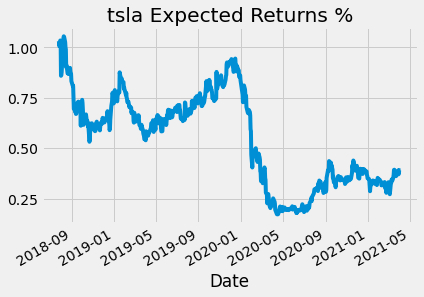

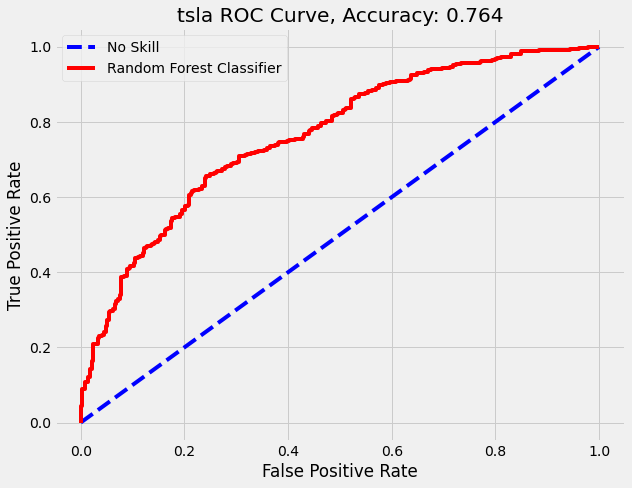

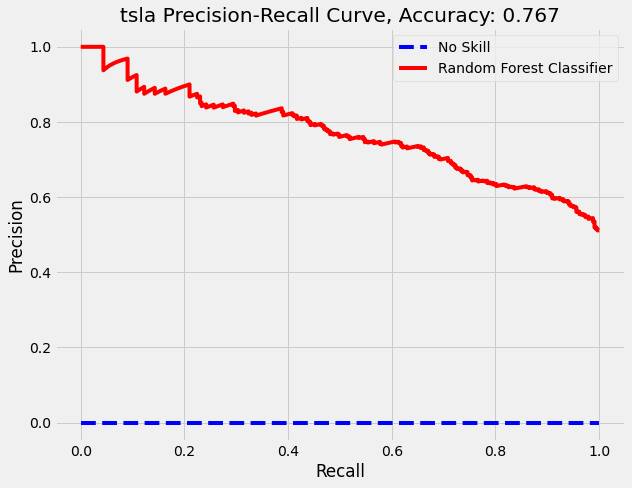

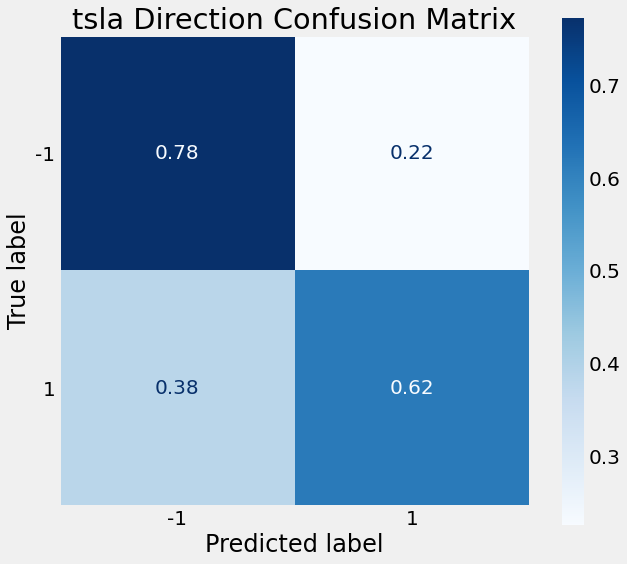

In [27]:
stock_name = 'tsla'
a.all_func(stock_name
           , start_dates[stock_name]
           , days_ahead = 5
           , model_name = model_name
           , days_back = 1
          )

### Data Frame of Predictions 1 3 5 Days

In [28]:
from datetime import date

today = date.today()
print("Today's date:", today)

Today's date: 2021-04-06


In [29]:
summary_df = a.pred_summary_df(start_dates1, stocks = [x for x in start_dates1], days_back = 1)
summary_df

,stock,1_Day_Pred,1_Day_Model_Return,3_Day_Pred,3_Day_Model_Return,5_Day_Pred,5_Day_Model_Return,Actual_Returns
0,a,Hold or Sell,3.5958,Hold or Sell,4.1846,Hold or Sell,4.0959,7.4886
1,aapl,Hold or Sell,3.1503,Hold or Sell,3.6106,Hold or Sell,3.6978,310.6198
2,acy,Hold or Sell,1.3732,Hold or Sell,0.6789,Hold or Sell,0.6739,2.4653
3,adbe,Hold or Sell,7.2118,Hold or Sell,7.1683,Hold or Sell,6.5755,80.5121
4,alb,Buy,2.0035,Buy,1.8706,Buy,1.7174,12.6177
5,amat,Buy,7.2631,Buy,8.4835,Buy,8.7805,243.9553
6,amd,Hold or Sell,9.4499,Hold or Sell,6.8955,Hold or Sell,9.9631,16.6065
7,amgn,Hold or Sell,5.2346,Hold or Sell,5.3503,Hold or Sell,5.2088,25.8821
8,amzn,Hold or Sell,3.7812,Hold or Sell,3.7226,Hold or Sell,4.3033,97.9795
9,baba,Buy,1.4768,Buy,1.3945,Buy,1.3496,1.8415


In [30]:
summary_df['1_Day_Model_Return'].median(), summary_df['3_Day_Model_Return'].median(), summary_df['5_Day_Model_Return'].median(), summary_df['Actual_Returns'].median()

(3.5958, 3.7226, 4.0959, 15.0649)

In [31]:
summary_df = a.pred_summary_df(start_dates2, stocks = [x for x in start_dates2], days_back = 1)
summary_df

,stock,1_Day_Pred,1_Day_Model_Return,3_Day_Pred,3_Day_Model_Return,5_Day_Pred,5_Day_Model_Return,Actual_Returns
0,esgv,Hold or Sell,1.1248,Hold or Sell,1.1768,Hold or Sell,1.1175,0.5202
1,fslr,Buy,2.2113,Buy,1.7928,Buy,1.6653,-0.2698
2,goog,Hold or Sell,2.6678,Hold or Sell,2.2660,Hold or Sell,3.4100,10.7784
3,ibm,Hold or Sell,2.9004,Hold or Sell,4.6566,Hold or Sell,4.2248,7.0254
4,intc,Hold or Sell,5.8034,Hold or Sell,5.9500,Hold or Sell,5.5729,44.3038
5,iyw,Hold or Sell,3.8023,Hold or Sell,4.4614,Hold or Sell,3.0404,6.6056
6,lng,Buy,1.1862,Buy,0.6979,Buy,1.3229,58.8824
7,ma,Hold or Sell,2.4168,Hold or Sell,2.2738,Hold or Sell,2.3292,15.5910
8,mdb,Hold or Sell,0.6886,Hold or Sell,0.7769,Hold or Sell,0.7157,2.6821
9,msft,Hold or Sell,8.4672,Hold or Sell,9.0338,Hold or Sell,6.1135,62.1306


In [32]:
summary_df['1_Day_Model_Return'].median(), summary_df['3_Day_Model_Return'].median(), summary_df['5_Day_Model_Return'].median(), summary_df['Actual_Returns'].median()

(2.4168, 2.2738, 2.6709, 12.0302)

In [33]:
summary_df = a.pred_summary_df(start_dates3, stocks = [x for x in start_dates3], days_back = 1)
summary_df

,stock,1_Day_Pred,1_Day_Model_Return,3_Day_Pred,3_Day_Model_Return,5_Day_Pred,5_Day_Model_Return,Actual_Returns
0,pypl,Hold or Sell,2.6466,Buy,2.4672,Hold or Sell,2.6340,5.3469
1,qgen,Hold or Sell,1.9612,Hold or Sell,2.1302,Hold or Sell,2.6918,7.9612
2,run,Buy,1.2847,Buy,1.2883,Buy,0.9741,8.1933
3,okta,Buy,1.0024,Buy,0.8983,Buy,0.9724,4.5883
4,orcl,Hold or Sell,2.8280,Hold or Sell,3.0096,Hold or Sell,3.1490,36.6612
5,qqq,Hold or Sell,3.3076,Hold or Sell,3.9811,Hold or Sell,2.5192,8.4802
6,srpt,Buy,2.2082,Buy,2.1392,Buy,1.7411,1.3080
7,tpic,Buy,1.2067,Buy,1.6205,Buy,1.3086,1.5967
8,tsla,Buy,4.2617,Buy,1.9776,Buy,2.7499,96.9102
9,v,Hold or Sell,2.5763,Hold or Sell,2.4689,Hold or Sell,2.5591,10.8576


In [34]:
summary_df['1_Day_Model_Return'].median(), summary_df['3_Day_Model_Return'].median(), summary_df['5_Day_Model_Return'].median(), summary_df['Actual_Returns'].median()

(2.5763, 2.1392, 2.5192, 5.6319)